In [1]:
from keras.datasets import cifar10

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [2]:
type(X_train), X_train.shape

(numpy.ndarray, (50000, 32, 32, 3))

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import numpy as np

# taking 16 images
indices = np.random.randint(0, X_train.shape[0], size=(20,))
indices

array([46923,  8501,  6194, 19445, 15489, 30384, 11164, 15676, 25490,
       37767, 14127, 29102, 25288, 21006, 46561, 42393, 18402, 38312,
       21846, 21988])

In [5]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

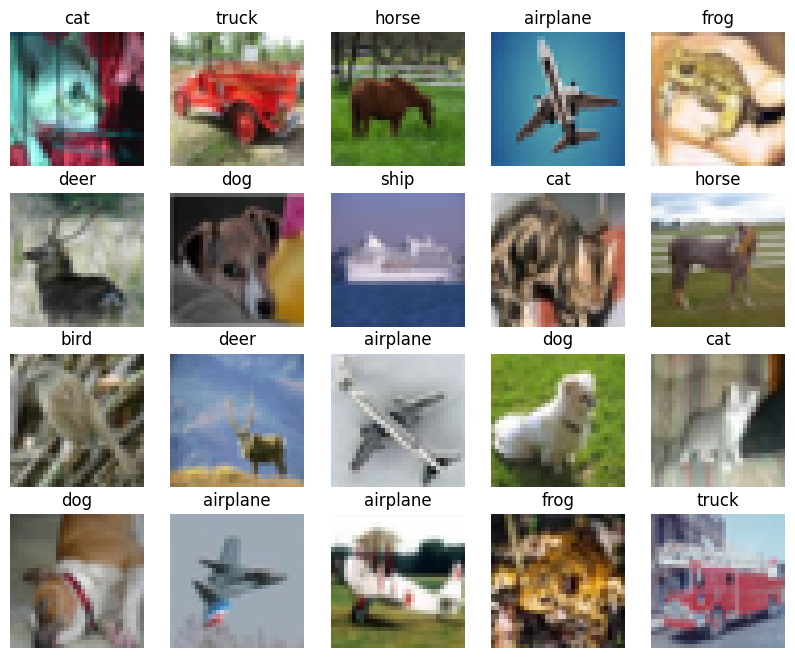

In [6]:
plt.figure(figsize=(10, 8))

for i, idx in enumerate(indices):
    img, label = X_train[idx], y_train[idx][0]
    name = class_names[label]

    plt.subplot(4, 5, i+1)
    plt.imshow(img)
    plt.title(name)
    plt.axis('off')
plt.show()

In [7]:
import mlx.core as mx
import mlx.nn as nn
import mlx.optimizers as optim
from functools import partial

class CIFAR10Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 32, (4, 4)),
            nn.ReLU(),
            nn.Conv2d(32, 32, (4, 4)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)), # 32x32x3 -> 26x26x32 -> 13x13x32
            nn.Conv2d(32, 64, (4, 4)),
            nn.ReLU(),
            nn.Conv2d(64, 64, (4, 4)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)), # 13x13x32 -> 7x7x64 -> 3x3x64
        )
        self.fc = nn.Sequential(
            nn.Linear(3*3*64, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            # nn.Softmax(),
        )
    
    def __call__(self, x) -> mx.array:
        x = self.feature_extractor(x)
        x = mx.flatten(x, start_axis=1)
        x = self.fc(x)
        return x
    
    def predict_class(self, x) -> mx.array:
        x = self(x)
        return mx.argmax(x, axis=-1)

model = CIFAR10Classifier()
mx.eval(model.parameters())
optimizer = optim.RMSprop(learning_rate=1e-3)

In [8]:
def calculate_metrics(y_true_onehot, y_pred_onehot):
    y_true_labels = mx.argmax(y_true_onehot, axis=1)
    y_pred_labels = mx.argmax(y_pred_onehot, axis=1)
    
    # Accuracy
    accuracy = mx.mean(y_true_labels == y_pred_labels)
    
    # Precision per class
    n_classes = y_true_onehot.shape[1]
    precisions = []
    
    for class_idx in range(n_classes):
        tp = mx.sum((y_pred_labels == class_idx) & (y_true_labels == class_idx))
        fp = mx.sum((y_pred_labels == class_idx) & (y_true_labels != class_idx))
        
        precision = tp / ((tp + fp) + 1e-8)
        precisions.append(precision)
    
    # Macro precision
    precisions = mx.stack(precisions)
    macro_precision = mx.mean(precisions)
    
    return (accuracy, macro_precision)

In [9]:
state = [model.state, optimizer.state]

def loss_fn(model, X, y):
    preds = model(X)
    loss = nn.losses.cross_entropy(logits=preds, targets=y, reduction='mean')
    accuracy, macro_precision = calculate_metrics(y, preds)
    return (loss, accuracy, macro_precision)

@partial(mx.compile, inputs=state, outputs=state)
def train_step(X, y):
    grad_fn = nn.value_and_grad(model, loss_fn)
    res, grads = grad_fn(model, X, y)
    loss, accuracy, macro_precision = res
    optimizer.update(model, grads)
    return loss, accuracy, macro_precision

In [10]:
def to_one_hot(labels, n_classes):
    """
    Convert array of labels to one-hot encoding.
    
    Args:
        labels: 1D array of integer labels
        n_classes: Number of classes (if None, inferred from data)
    
    Returns:
        2D array of one-hot encoded vectors
    """
    labels = labels.reshape(-1)
    n_classes = n_classes
    return np.eye(n_classes, dtype=int)[labels]

In [11]:
X_train_mx = mx.array(X_train)
y_train_mx = mx.array(to_one_hot(y_train, 10))

print("Training data ready")

Training data ready


In [12]:
X_train.min(), X_train.max()

(np.uint8(0), np.uint8(255))

In [13]:
%%time

history = []
BATCH_SIZE = 128

for epoch in range(20):
    # Calculate actual number of batches
    num_batches = X_train.shape[0] // BATCH_SIZE
    
    # Allocate arrays sized to number of batches
    running_loss = mx.zeros((num_batches,))
    running_acc = mx.zeros((num_batches,))
    running_pr = mx.zeros((num_batches,))
    
    for batch_idx in range(num_batches):
        # Sample random indices for this batch
        idx = mx.random.randint(0, X_train.shape[0], (BATCH_SIZE,))
        X_batch = X_train_mx[idx].astype(mx.float32) / 255.0
        y_batch = y_train_mx[idx]

        loss, accuracy, macro_precision = train_step(X_batch, y_batch)

        # Store metrics using batch_idx (0, 1, 2, ...)
        running_loss[batch_idx] = loss
        running_acc[batch_idx] = accuracy
        running_pr[batch_idx] = macro_precision

    # Calculate epoch metrics
    h = [
        mx.mean(running_loss).item(),
        mx.mean(running_acc).item(),
        mx.mean(running_pr).item(),
    ]
    history.append(h)

    print(f"Epoch: {epoch+1}, Loss {h[0]:.4f}, Accuracy {h[1]:.4f}, Macro Precision {h[2]:.4f}")

Epoch: 1, Loss 1.9824, Accuracy 0.2911, Macro Precision 0.2746
Epoch: 2, Loss 1.5048, Accuracy 0.4579, Macro Precision 0.4741
Epoch: 3, Loss 1.2730, Accuracy 0.5442, Macro Precision 0.5648
Epoch: 4, Loss 1.1159, Accuracy 0.6071, Macro Precision 0.6267
Epoch: 5, Loss 0.9809, Accuracy 0.6597, Macro Precision 0.6797
Epoch: 6, Loss 0.8752, Accuracy 0.6965, Macro Precision 0.7120
Epoch: 7, Loss 0.7763, Accuracy 0.7321, Macro Precision 0.7472
Epoch: 8, Loss 0.6892, Accuracy 0.7621, Macro Precision 0.7742
Epoch: 9, Loss 0.6197, Accuracy 0.7881, Macro Precision 0.7986
Epoch: 10, Loss 0.5490, Accuracy 0.8133, Macro Precision 0.8213
Epoch: 11, Loss 0.4813, Accuracy 0.8364, Macro Precision 0.8430
Epoch: 12, Loss 0.4280, Accuracy 0.8539, Macro Precision 0.8604
Epoch: 13, Loss 0.3688, Accuracy 0.8751, Macro Precision 0.8803
Epoch: 14, Loss 0.3268, Accuracy 0.8897, Macro Precision 0.8935
Epoch: 15, Loss 0.2872, Accuracy 0.9035, Macro Precision 0.9079
Epoch: 16, Loss 0.2455, Accuracy 0.9170, Macro Pr

In [14]:
model.save_weights("large_cifar_10.npz")

In [15]:
mx.savez("test", X_test=mx.array(X_test), y_test=mx.array(y_test))

In [16]:
history

[[1.9824256896972656, 0.29114583134651184, 0.27459099888801575],
 [1.5047696828842163, 0.45789265632629395, 0.4740941822528839],
 [1.2730084657669067, 0.5442307591438293, 0.564815878868103],
 [1.115873098373413, 0.607111394405365, 0.6266767382621765],
 [0.9809159636497498, 0.6596955060958862, 0.6797382831573486],
 [0.8751678466796875, 0.6964743733406067, 0.7120471596717834],
 [0.77630215883255, 0.7320513129234314, 0.7471820712089539],
 [0.6892263889312744, 0.7621194124221802, 0.7742251753807068],
 [0.619732677936554, 0.7881210446357727, 0.7985572218894958],
 [0.5489828586578369, 0.8133013248443604, 0.8212748169898987],
 [0.4812506437301636, 0.8364182710647583, 0.8429925441741943],
 [0.4280356168746948, 0.8539263010025024, 0.8604457974433899],
 [0.3687744736671448, 0.8750601410865784, 0.8803335428237915],
 [0.3268450200557709, 0.8896835446357727, 0.8934648036956787],
 [0.2871801555156708, 0.9035056233406067, 0.9079011082649231],
 [0.24553309381008148, 0.9170272946357727, 0.9205388426780

In [17]:
import pandas as pd

history_df = pd.DataFrame(history, columns=['Loss', 'Accuracy', 'Macro Precision'])
history_df.head()

,Loss,Accuracy,Macro Precision
0,1.982426,0.291146,0.274591
1,1.504770,0.457893,0.474094
2,1.273008,0.544231,0.564816
3,1.115873,0.607111,0.626677
4,0.980916,0.659696,0.679738


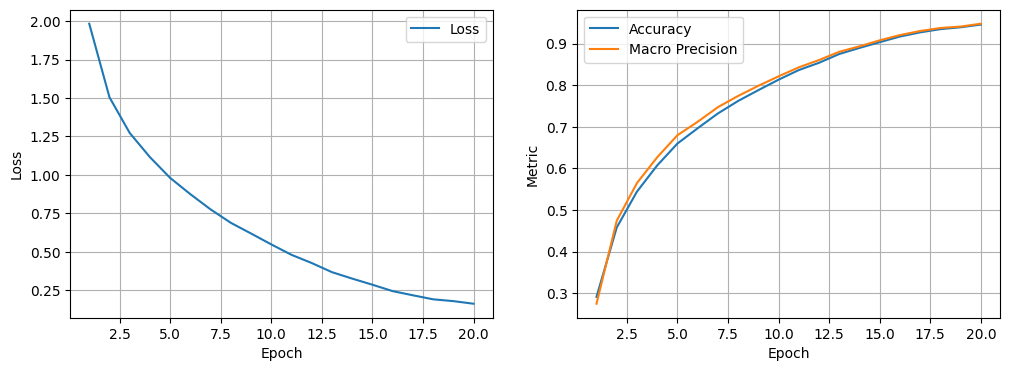

In [25]:
plt.figure(figsize=(12, 4))

epochs = np.arange(1, 21)

plt.subplot(1, 2, 1)
plt.plot(epochs, history_df.Loss, label='Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history_df.Accuracy, label='Accuracy')
plt.plot(epochs, history_df['Macro Precision'], label='Macro Precision')
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.grid()
plt.legend()

plt.show()